# Evaluation of Figure 2

In this notebook, the data for Figure 2 is prepared. Note, that due to known issues in the umap-learn package, the plots are not 100% reproducable over all machines. However the overall structure will be preserved.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import scanpy as sc
import scirpy as ir
import anndata
import scipy

from matplotlib import rcParams
import matplotlib.pyplot as plt

C:\Users\felix.drost\Anaconda3\envs\mvtcr_4\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append('../mvTCR')
import tcr_embedding.utils_training as utils
import config.constants_10x as const

In [3]:
sb.set_style("whitegrid")

In [4]:
def load_model(adata, model, weight=1):
    path_model = f'saved_models/journal/Haniffa/haniffa_tcr_{model}_{weight}.pt'
    model = utils.load_model(adata, path_model)
    return model
    

In [5]:
def load_data():
    adata = utils.load_data('Haniffa')
    return adata

In [6]:
path_out = '../results/fig2_haniffa_lv.h5ad'

## Loading

In [7]:
data = load_data()

In [8]:
data.shape

(103761, 5000)

In [9]:
data.obs['patient_id'].nunique()

94

## Database Query

In [10]:
data.obs = data.obs.rename(columns={'cdr3_alpha': 'IR_VJ_1_junction_aa',
                                    'cdr3_beta': 'IR_VDJ_1_junction_aa'})
data.obs['IR_VJ_2_junction_aa'] = [None] * len(data)
data.obs['IR_VDJ_2_junction_aa'] = [None] * len(data)
data.obs['has_ir'] = [True] * len(data)

In [11]:
data.uns['scirpy_version'] = '0.7'

#### VDJdb Query

vdjdb = ir.datasets.vdjdb()
data.uns['scirpy_version'] = '0.7'
#vdjdb_covid = vdjdb[vdjdb.obs['antigen.species']=='SARS-CoV-2']
ir.pp.ir_dist(data, vdjdb, metric='alignment', sequence='aa')
ir.tl.ir_query(data, vdjdb, metric='alignment', sequence='aa', receptor_arms='VDJ', dual_ir='primary_only')
ir.tl.ir_query_annotate(data, vdjdb, metric='alignment', sequence='aa', strategy='json',
                        include_ref_cols=['antigen.species', 'antigen.gene', 'antigen.epitope'])

data.obs = data.obs.rename(columns={'antigen.species': 'vdj_specie',
                                    'antigen.gene': 'vdj_gene',
                                    'antigen.epitope': 'vdj_epitope'
                                   })
#data.obs['vdj_specie'].value_counts()

In [12]:
data.obs['vdj_specie'] = np.nan
data.obs['vdj_epitope'] = np.nan
data.obs['vdj_gene'] = np.nan

data.obs['mira_specie'] = np.nan
data.obs['mira_epitope'] = np.nan
data.obs['mira_gene'] = np.nan

#### Mira

mira_cd8 = pd.read_csv('../../data/databases/ImmuneCODE-MIRA-Release002.1/peptide-detail-ci.csv')
mira_cd8['IR_VDJ_1_junction_aa'] = mira_cd8['TCR BioIdentity'].str.split('+', expand=True)[0]
mira_cd8 = mira_cd8[mira_cd8['IR_VDJ_1_junction_aa']!='unproductive']
mira_cd8 = mira_cd8[['ORF Coverage', 'IR_VDJ_1_junction_aa', 'Amino Acids']]
mira_cd8 = mira_cd8.drop_duplicates().reset_index(drop=True)
mira_cd8['mira_specie'] = 'SARS-CoV-2'
mira_cd8['has_ir'] = True
mira_cd8 = mira_cd8.rename(columns={'ORF Coverage': 'mira_gene', 'Amino Acids': 'mira_epitope'})

for col in ['IR_VJ_1_junction_aa', 'IR_VJ_2_junction_aa', 'IR_VDJ_2_junction_aa']:
    mira_cd8[col] = None

mira_cd8 = sc.AnnData(obs=mira_cd8)
mira_cd8.uns['DB'] = {'name': 'MiraCd8'}
mira_cd8

ir.pp.ir_dist(data, mira_cd8, metric='alignment', sequence='aa')
ir.tl.ir_query(data, mira_cd8, metric='alignment', sequence='aa', receptor_arms='VDJ', dual_ir='primary_only')
ir.tl.ir_query_annotate(data, mira_cd8, metric='alignment', sequence='aa', strategy='json',
                        include_ref_cols=['mira_specie', 'mira_gene', 'mira_epitope'])
#data.obs['mira_specie'].value_counts()

#### IEDB

In [13]:
iedb = pd.read_csv('../data/IEDB.csv')
iedb = iedb[iedb['Receptor Type']=='alphabeta']
iedb = iedb[['Description', 'Antigen', 'Organism', 'MHC Allele Names',
             'Chain 1 CDR3 Calculated', 'Chain 2 CDR3 Calculated']]
iedb = iedb[~iedb['Chain 2 CDR3 Calculated'].isna() | ~iedb['Chain 1 CDR3 Calculated'].isna()]
#iedb = iedb[iedb['Organism']=='SARS-CoV2']
iedb = iedb.rename(columns={'Chain 1 CDR3 Calculated': 'IR_VJ_1_junction_aa', 
                            'Chain 2 CDR3 Calculated': 'IR_VDJ_1_junction_aa',
                            'Description': 'iedb_epitope',
                            'Antigen': 'iedb_gene',
                            'Organism': 'iedb_specie'
                           })
iedb = iedb[['IR_VJ_1_junction_aa', 'IR_VDJ_1_junction_aa', 'iedb_epitope', 'iedb_gene', 'iedb_specie']]
iedb['IR_VDJ_1_junction_aa'] = 'C' + iedb['IR_VDJ_1_junction_aa'] + 'F'
iedb['has_ir'] = True
iedb = iedb.drop_duplicates().reset_index(drop=True)
for col in ['IR_VJ_2_junction_aa', 'IR_VDJ_2_junction_aa']:
    iedb[col] = None
    
iedb = sc.AnnData(obs=iedb)
iedb.uns['DB'] = {'name': 'IEDB'}
iedb

AnnData object with n_obs × n_vars = 122523 × 0
    obs: 'IR_VJ_1_junction_aa', 'IR_VDJ_1_junction_aa', 'iedb_epitope', 'iedb_gene', 'iedb_specie', 'has_ir', 'IR_VJ_2_junction_aa', 'IR_VDJ_2_junction_aa'
    uns: 'DB'

In [14]:
ir.pp.ir_dist(data, iedb, metric='levenshtein', sequence='aa', cutoff=1)
ir.tl.ir_query(data, iedb, metric='levenshtein', sequence='aa', receptor_arms='VDJ', dual_ir='primary_only')
ir.tl.ir_query_annotate(data, iedb, metric='levenshtein', sequence='aa', strategy='json',
                        include_ref_cols=['iedb_specie', 'iedb_gene', 'iedb_epitope'])
#data.obs['iedb_specie'].value_counts()

100%|████████████████████████████████████████████████████████████████████████| 115536/115536 [00:28<00:00, 4100.73it/s]


#### Save Annotated Data

In [15]:
for col in ['IR_VJ_2_junction_aa', 'IR_VDJ_2_junction_aa']:
    data.obs[col] = data.obs[col].astype(str)
sc.write(adata=data, filename=path_out)

## Latent and UMAPs

In [16]:
data = sc.read(filename=path_out)
models = {model_name: load_model(data, model_name) for model_name in ['moe', 'rna']}

### Add HLA data

In [17]:
metadata = [
       'full_clustering',
       'Collection_Day', 'Sex',
       'Age_interval', 'Swab_result', 'Status', 'Smoker',
       'Status_on_day_collection', 'Status_on_day_collection_summary',
       'Days_from_onset', 'Site', 'Worst_Clinical_Status',
       'Outcome', 'patient_id', ]

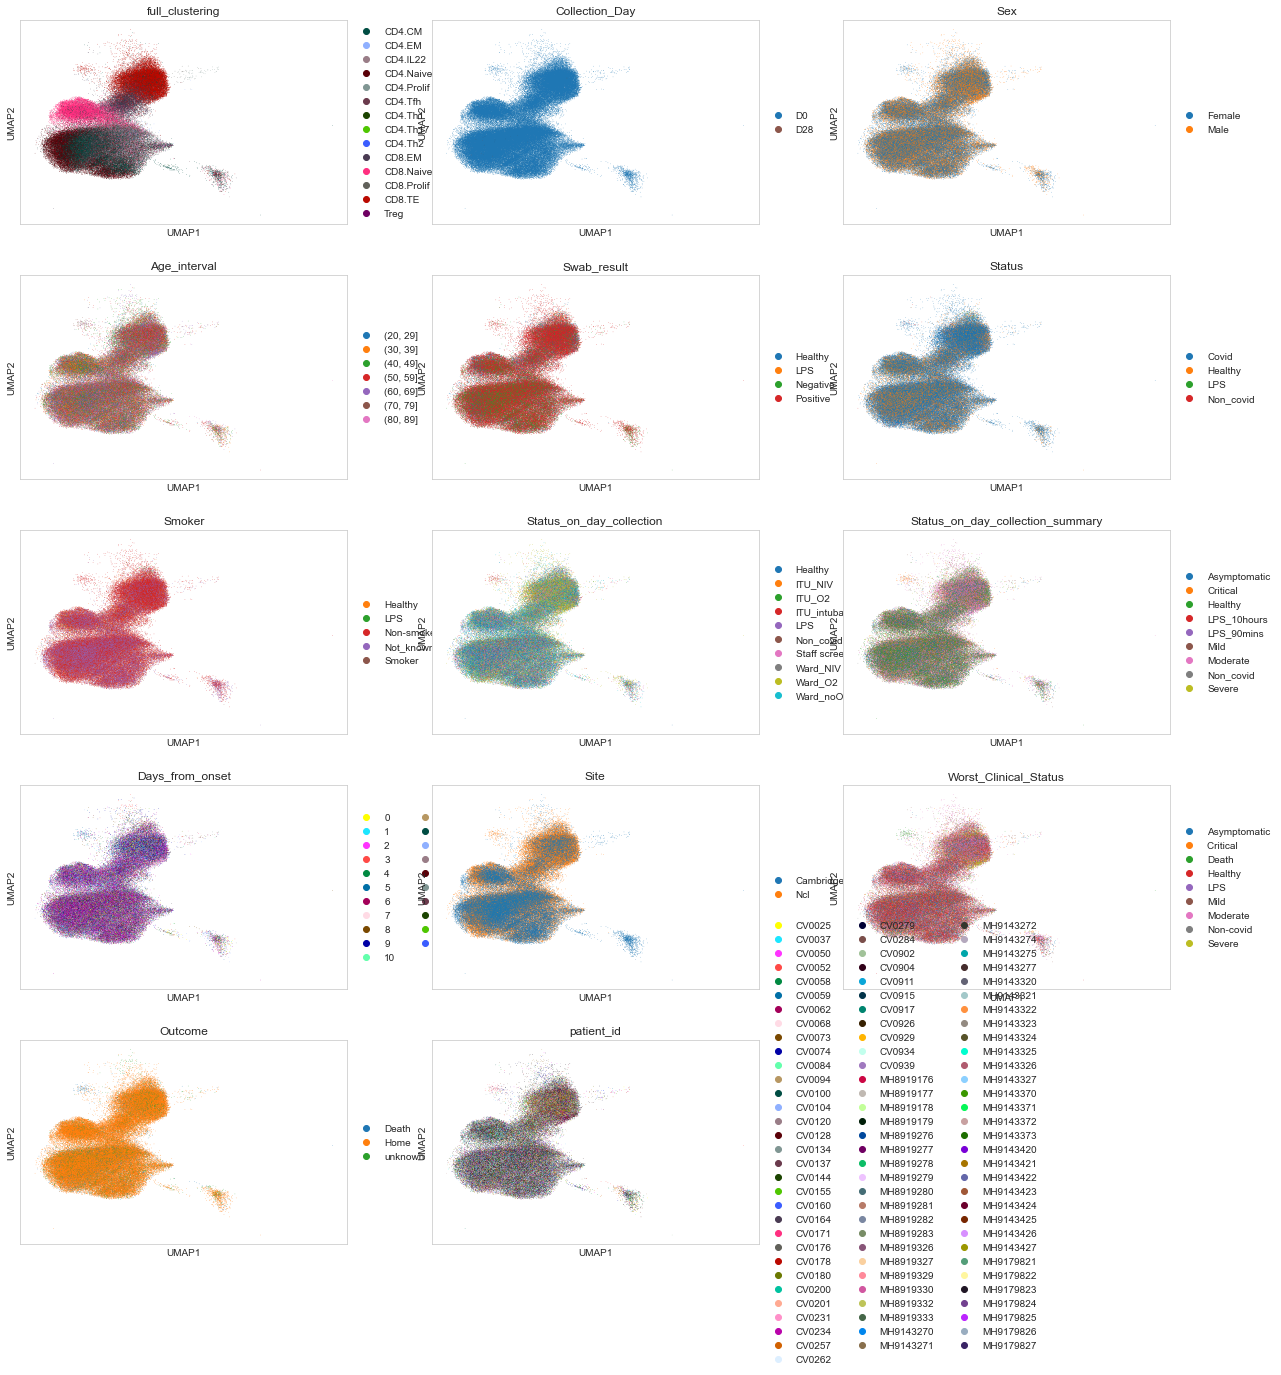

In [18]:
sc.pl.umap(data, color=metadata, ncols=3)

In [19]:
moe_model = models['moe']
latent_moe = moe_model.get_latent(data, metadata=metadata, return_mean=True)
sc.pp.neighbors(latent_moe, use_rep='X')
sc.tl.umap(latent_moe)
data.obsm['X_umap_moe'] = latent_moe.obsm['X_umap']

In [20]:
rna_model = models['rna']
latent_rna = rna_model.get_latent(data, metadata=metadata)
sc.pp.neighbors(latent_rna, use_rep='X')
sc.tl.umap(latent_rna)
data.obsm['X_umap_rna'] = latent_rna.obsm['X_umap']

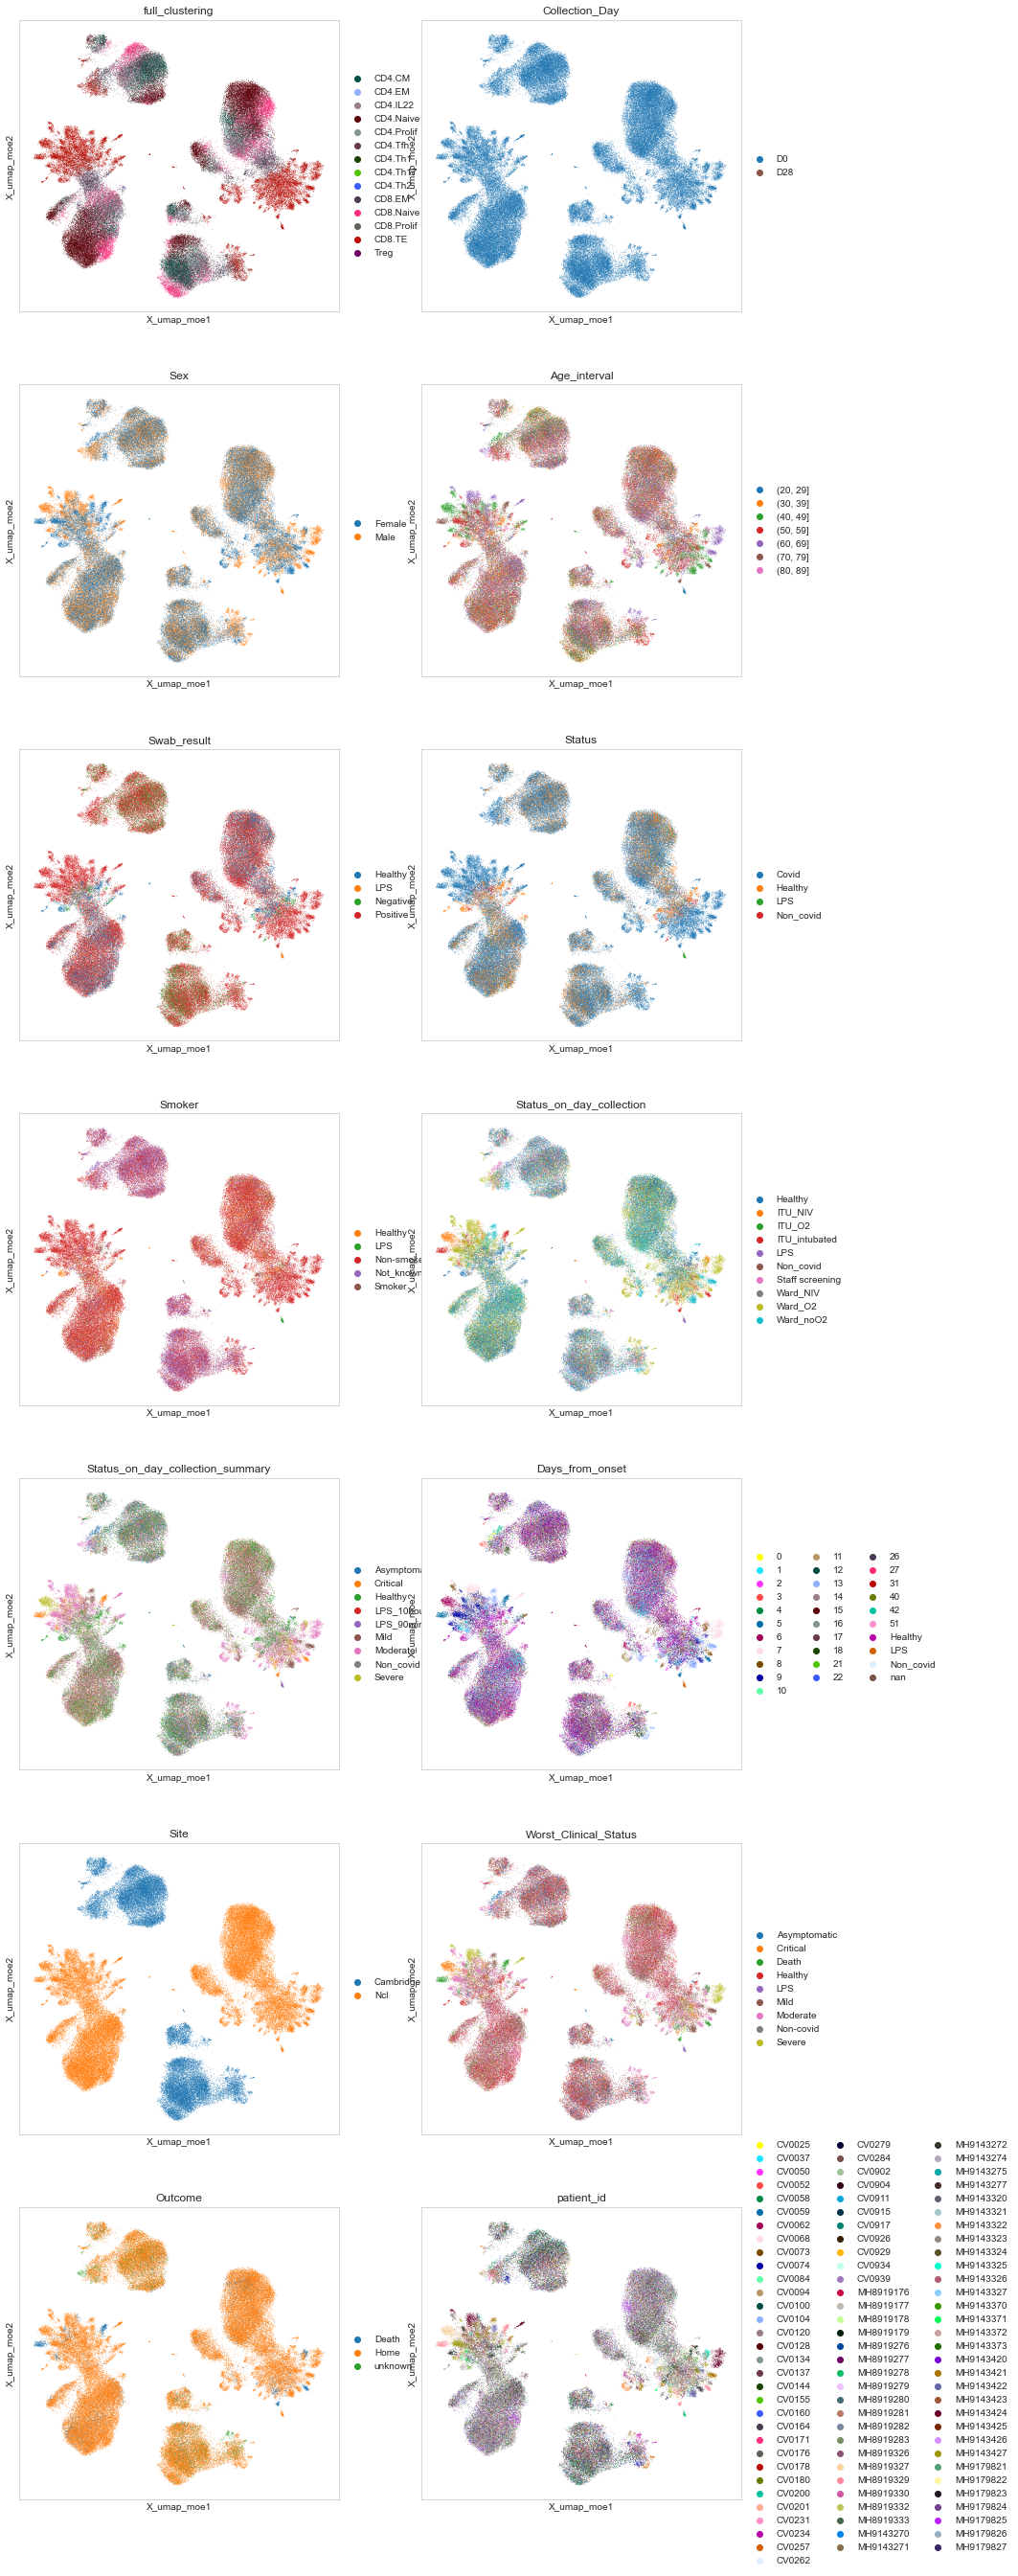

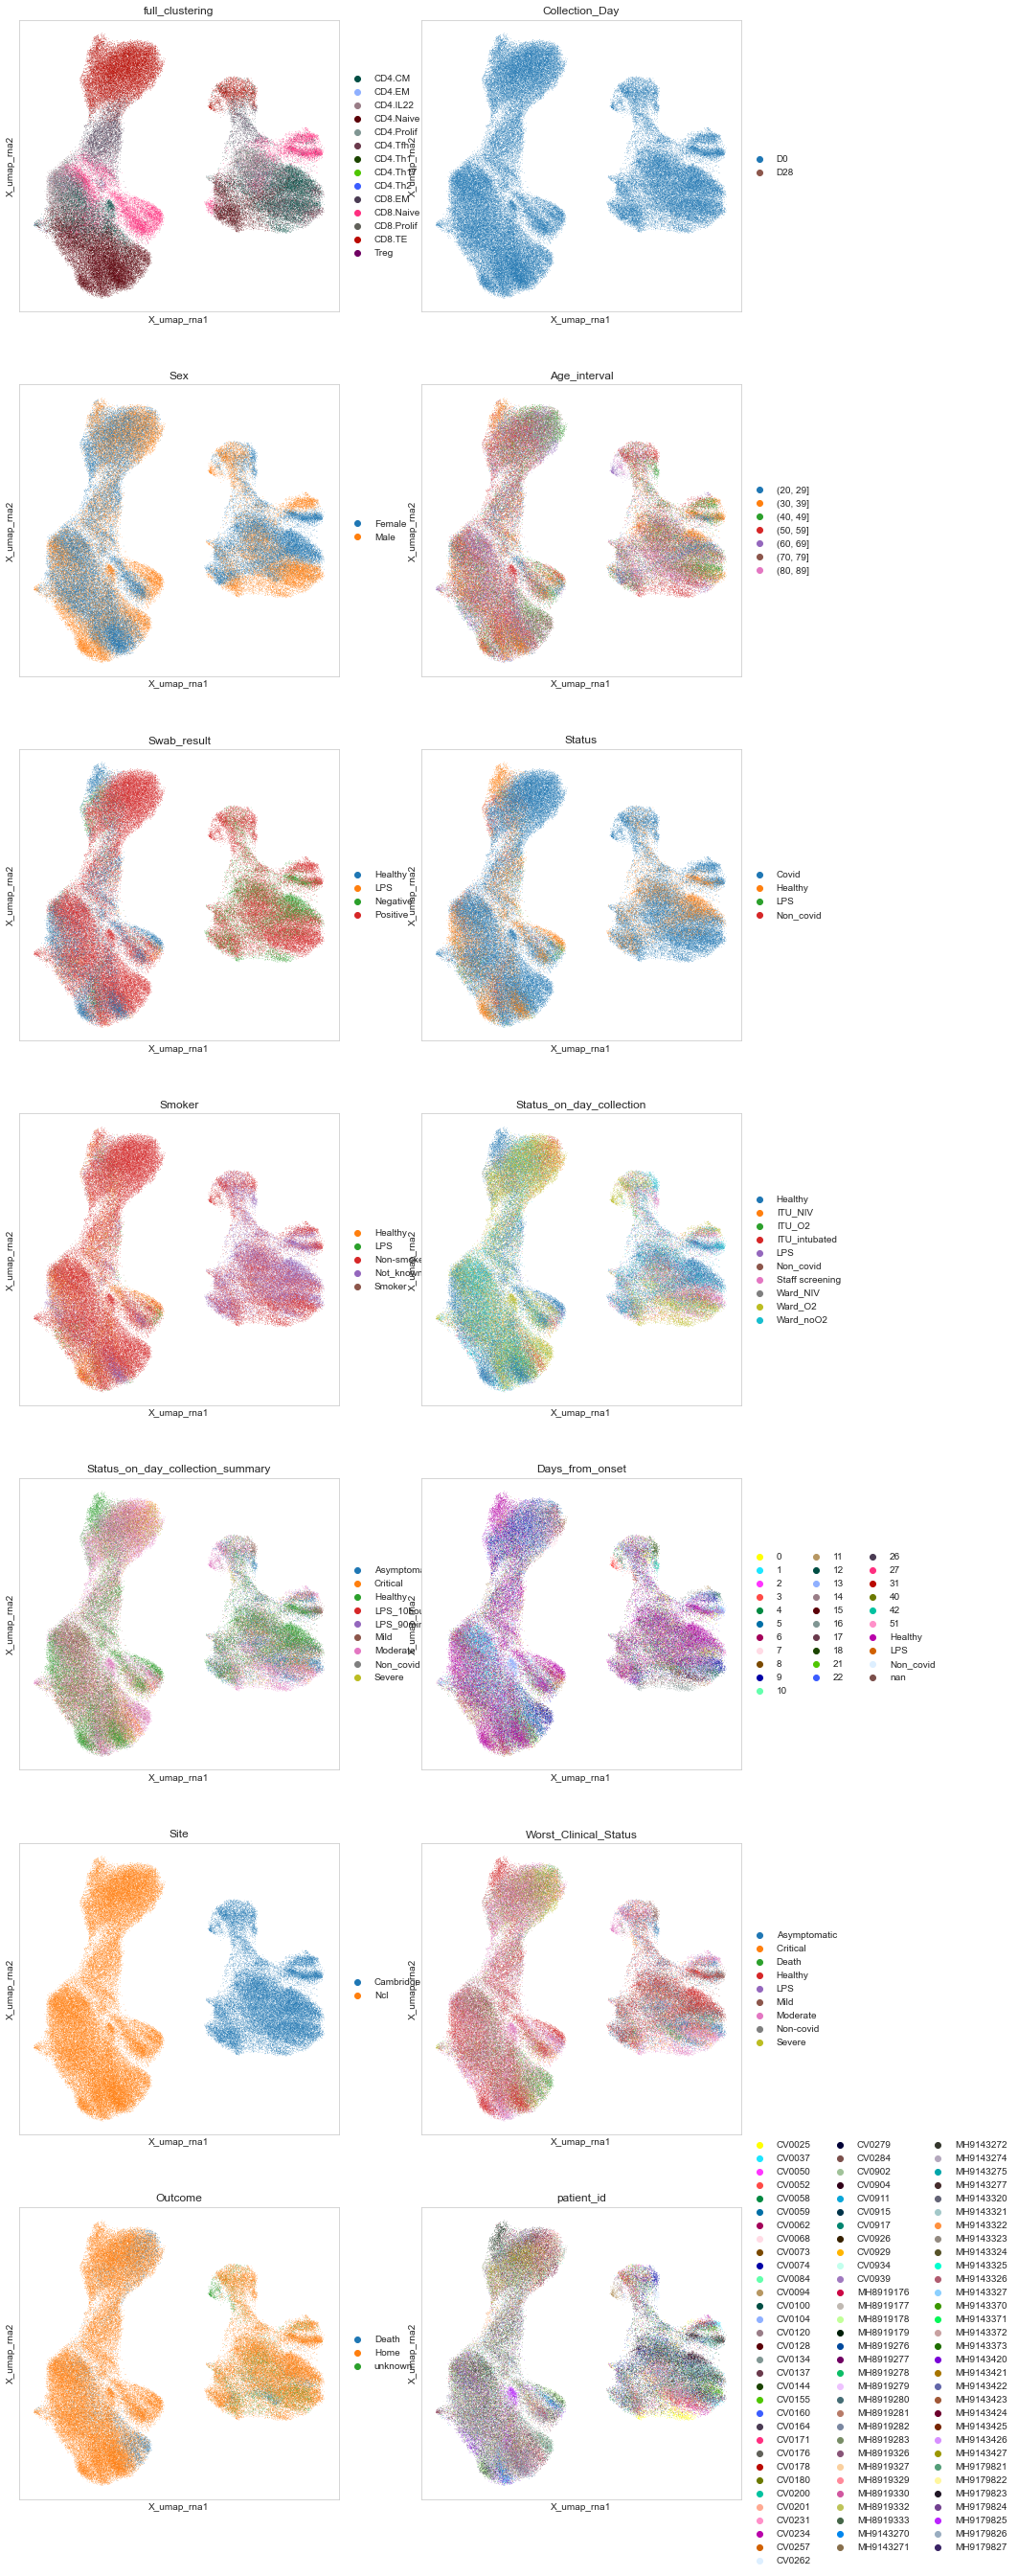

In [21]:
rcParams['figure.figsize'] = (6, 6)
sc.pl.embedding(data, basis='X_umap_moe', color=metadata, ncols=2)
sc.pl.embedding(data, basis='X_umap_rna', color=metadata, ncols=2)

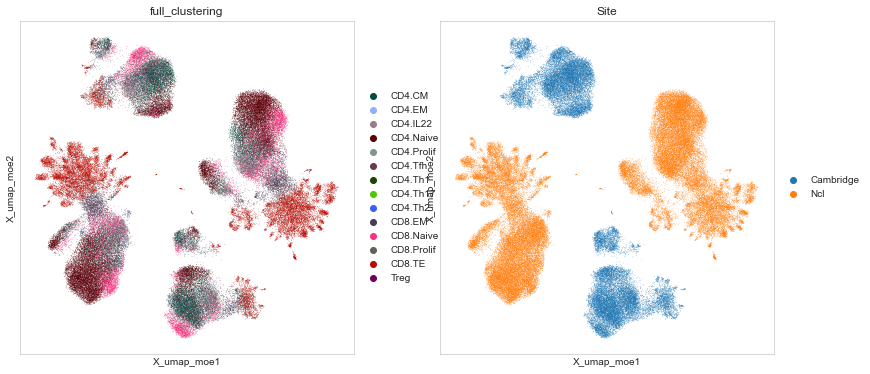

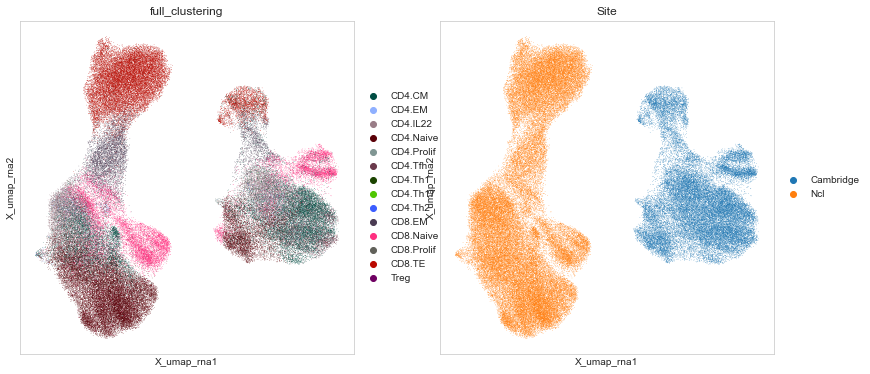

In [22]:
sc.pl.embedding(data, basis='X_umap_moe', color=['full_clustering', 'Site'], ncols=2)
sc.pl.embedding(data, basis='X_umap_rna', color=['full_clustering', 'Site'], ncols=2)

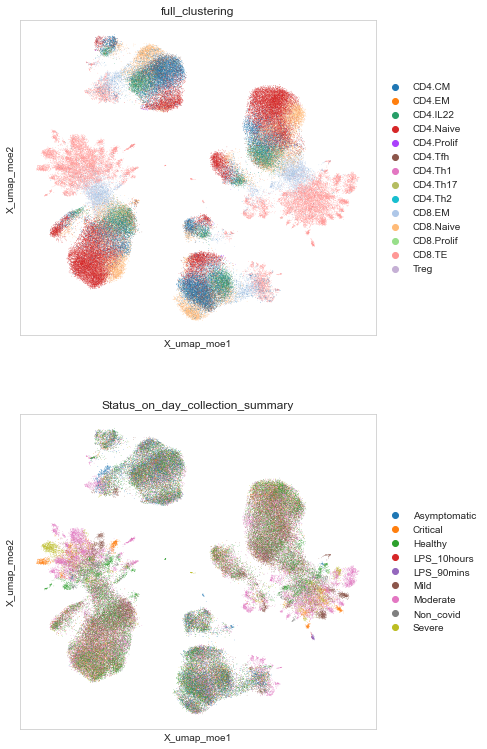

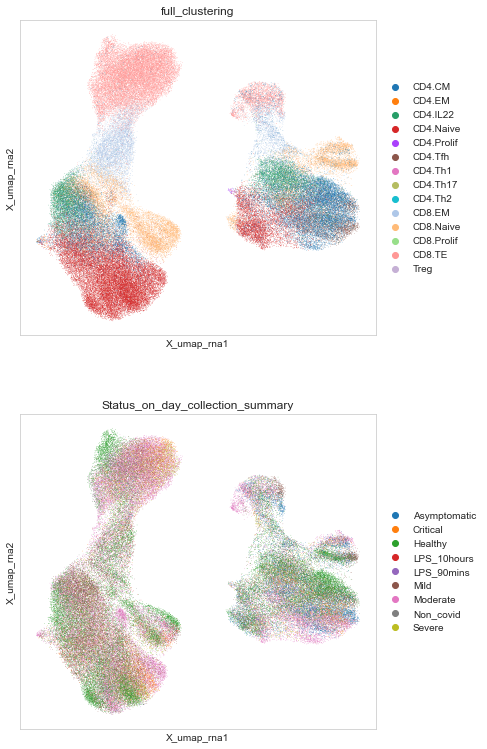

In [23]:
rcParams['figure.figsize'] = (6, 6)
data.uns.pop('full_clustering_colors')
sc.pl.embedding(data, basis='X_umap_moe', color=['full_clustering', 'Status_on_day_collection_summary'], ncols=1)
sc.pl.embedding(data, basis='X_umap_rna', color=['full_clustering', 'Status_on_day_collection_summary'], ncols=1)

data.obs['mira_gene'].value_counts()

cols_dbs = ['vdj_specie', 'mira_specie', 'iedb_specie']
sc.pl.embedding(data, basis='X_umap_moe', color=cols_dbs, ncols=1, size=2)
sc.pl.embedding(data, basis='X_umap_rna', color=cols_dbs, ncols=1, size=2)

iedb_top_classes = data.obs['iedb_specie'].value_counts()
iedb_top_classes = iedb_top_classes[iedb_top_classes>15].index.tolist()
iedb_top_classes

data.obs['iedb_specie'].loc[~data.obs['iedb_specie'].isin(iedb_top_classes)] = np.nan
data.obs['iedb_specie'] = data.obs['iedb_specie'].astype(str)
data.obs['iedb_specie'].value_counts()

vdj_top_classes = data.obs['vdj_specie'].value_counts()
vdj_top_classes = vdj_top_classes[vdj_top_classes>100].index.tolist()

data.obs['vdj_specie'].loc[~data.obs['vdj_specie'].isin(vdj_top_classes)] = np.nan
data.obs['vdj_specie'] = data.obs['vdj_specie'].astype(str)
data.obs['vdj_specie'].value_counts()

## Add Marker Genes / Scores

In [24]:
tcell_markers = pd.read_excel('additional_data/41467_2019_12464_MOESM7_ESM.xlsx', skiprows=1)
tcell_markers

FileNotFoundError: [Errno 2] No such file or directory: 'additional_data/41467_2019_12464_MOESM7_ESM.xlsx'

In [ ]:
for k, v in tcell_markers.items():
    score_name = k.lower() + "_score"
    data.obs[score_name] = np.mean(
        (
            data[:, [x for x in v if x in data.var_names]].X - 
            data[:, [x for x in v if x in data.var_names]].X.mean(axis=0)
        ) / data[:, [x for x in v if x in data.var_names]].X.todense().std(axis=0),
        axis=1)

In [ ]:
expanded_clonotypes = data.obs['clonotype'].value_counts()
expanded_clonotypes = expanded_clonotypes[expanded_clonotypes>=50].index

data.obs['large_clonotype'] = [el if el in expanded_clonotypes
                              else '-99' 
                              for el in data.obs['clonotype']]

In [ ]:
scores = [k.lower() + "_score" for k in tcell_markers]

for score in scores:
    lower, upper = np.percentile(data.obs[score], [1, 99])
    sc.pl.embedding(data, basis='X_umap_moe', color=score, vmin=lower, vmax=upper, cmap='viridis')

In [ ]:
lower, upper = np.percentile(data.obs['ifn response_score'], [1, 99])
sc.pl.embedding(data, basis='X_umap_moe', color=score, vmin=lower, vmax=upper, cmap='viridis')
sc.pl.embedding(data, basis='X_umap_rna', color=score, vmin=lower, vmax=upper, cmap='viridis')

In [ ]:
activation_marker = ['CD38', 'HLA-DRA', 'MKI67', 'IFNG', 'CCL4', 'Status']
sc.pl.embedding(data, basis='X_umap_moe', color='Status_on_day_collection_summary', ncols=2, cmap='flare')
sc.pl.embedding(data, basis='X_umap_moe', color=activation_marker, ncols=2, cmap='flare')
sc.pl.embedding(data, basis='X_umap_rna', color='Status_on_day_collection_summary', ncols=2, cmap='flare')
sc.pl.embedding(data, basis='X_umap_rna', color=activation_marker, ncols=2, cmap='flare')

In [ ]:
data.obs['large_clonotype'] = data.obs['large_clonotype'].astype(str)
data.obs['large_clonotype'] = data.obs['large_clonotype'].replace('-99', np.nan) 

In [ ]:
#latent_moe.obs['mira_cd8'] = data.obs['mira_cd8']
sc.pl.embedding(data, basis='X_umap_moe', color=['IFNG', 'CCL4', 'cd8 cytokine_score'], ncols=3, cmap='viridis')
#sc.pl.umap(latent_moe, color='mira_cd8', groups='True', size=10)
#sc.pl.umap(latent_moe, color='antigen.species', size=10)
sc.pl.embedding(data, basis='X_umap_moe', color=['large_clonotype', 'patient_id'], size=10)

In [ ]:
sc.tl.leiden(latent_moe)
sc.pp.neighbors(data)
sc.tl.leiden(data)
data.obs['leiden_moe'] = latent_moe.obs['leiden']
sc.pl.embedding(data, basis='X_umap_moe', color=['leiden_moe', 'leiden'])

In [ ]:
rcParams['figure.figsize'] = (15, 3)
sc.pl.violin(data, keys='IFNG', groupby='leiden_moe', figsize=(20, 3))
sc.pl.violin(data, keys='IFNG', groupby='leiden', figsize=(20, 3))
rcParams['figure.figsize'] = (6, 6)

In [ ]:
latent_moe_cd8ef = latent_moe[latent_moe.obs['full_clustering']=='CD8.TE']
sc.pp.neighbors(latent_moe_cd8ef)
sc.tl.leiden(latent_moe_cd8ef, resolution=1)
data.obs['leiden_moe_cd8te'] = latent_moe_cd8ef.obs['leiden']
data_cd8te = data[data.obs['full_clustering']=='CD8.TE']

In [ ]:
sc.pl.embedding(data, basis='X_umap_moe', color='leiden_moe_cd8te')

In [ ]:
scores = [el for el in data.obs.columns.tolist() if el.endswith('_score')]

for color in scores:
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    sc.pl.embedding(data, basis='X_umap_moe', show=False, ax=ax)
    sc.pl.embedding(data_cd8te, basis='X_umap_moe', color=color, ax=ax, show=False, cmap='viridis')
    plt.show()

In [ ]:
for color in ['CCL4', 'IFNG']:
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    sc.pl.embedding(data, basis='X_umap_moe', show=False, ax=ax)
    sc.pl.embedding(data_cd8te, basis='X_umap_moe', color=color, ax=ax, show=False, cmap='viridis')
    plt.show()

In [ ]:
sc.pl.embedding(data_cd8te, basis='X_umap_rna', color='leiden_moe_cd8te', size=30)

In [ ]:
rcParams['figure.figsize'] = (15, 3)
sc.pl.violin(data, keys='cd8 cytokine_score', groupby='leiden_moe_cd8te', figsize=(20, 3))
rcParams['figure.figsize'] = (6, 6)

In [ ]:
rcParams['figure.figsize'] = (6, 6)
data.uns.pop('full_clustering_colors')
sc.pl.embedding(data, basis='X_umap_moe', color=['Status'])
sc.pl.embedding(data, basis='X_umap_moe', color=['Status_on_day_collection_summary'])
sc.pl.embedding(data, basis='X_umap_moe', color=['full_clustering'])
sc.pl.embedding(data, basis='X_umap_moe', color=['ifn response_score'], cmap='viridis')
sc.pl.embedding(data, basis='X_umap_moe', color=['large_clonotype'], cmap='viridis')


In [ ]:
ir.pl.group_abundance(data_cd8te, groupby='leiden_moe_cd8te', target_col='full_clustering', figsize=(20, 3))
rcParams['figure.figsize'] = (15, 3)
sc.pl.violin(data_cd8te, keys='cd8 cytokine_score', groupby='leiden_moe_cd8te', figsize=(20, 3))
rcParams['figure.figsize'] = (6, 6)

In [ ]:
ps_by_cluster = {}

score = 'ifn response_score'
for cluster in sorted(data_cd8te.obs['leiden_moe_cd8te'].unique().astype(int)):
    cluster = str(cluster)
    ifn_cluster = data_cd8te[data_cd8te.obs['leiden_moe_cd8te']==cluster].obs[score]
    ifn_rest = data_cd8te[data_cd8te.obs['leiden_moe_cd8te']!=cluster].obs[score]
    
    p_value = scipy.stats.ttest_ind(a=ifn_cluster, b=ifn_rest, equal_var=False, alternative='greater')
    #print(p_value)
    #print(p_value[1])
    ps_by_cluster[cluster] = p_value[1]
    #raise ValueError
ps_by_cluster = pd.DataFrame(data={'p_value': ps_by_cluster.values()}, index=ps_by_cluster.keys(),)
ps_by_cluster.index.name = 'cluster'
ps_by_cluster.head(5)

In [ ]:
def map_pvalue_sign(p):
    if p < 0.001:
        return '***'
    if p < 0.01:
        return '**'
    if p < 0.05:
        return '*'
    return ''
ps_by_cluster['sign'] = ps_by_cluster['p_value'].map(map_pvalue_sign)
ps_by_cluster['cluster+sign'] = ps_by_cluster.index + '\n' + ps_by_cluster['sign']
print(ps_by_cluster['sign'].value_counts())
ps_by_cluster.head()

In [ ]:
rcParams['figure.figsize'] = (15, 3)
plot = sc.pl.violin(data_cd8te, keys=score, groupby='leiden_moe_cd8te', figsize=(20, 3), show=False)
plot.set_xticklabels(ps_by_cluster['cluster+sign'].values)
rcParams['figure.figsize'] = (6, 6)

In [ ]:
react_leiden = ps_by_cluster[ps_by_cluster['sign']=='***'].index

In [ ]:
data.uns['p_values_ifn'] = ps_by_cluster
data.uns['reactive_clusters'] = list(react_leiden)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

sc.pl.embedding(data, basis='X_umap_moe', show=False, ax=ax)
sc.pl.embedding(data[data.obs['leiden_moe_cd8te'].isin(react_leiden)], basis='X_umap_moe', 
                color='leiden_moe_cd8te', ax=ax, show=False, cmap='viridis')
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sc.pl.embedding(data, basis='X_umap_moe', show=False, ax=ax[0])
sc.pl.embedding(data_cd8te, basis='X_umap_moe', color=score, ax=ax[0], show=False, cmap='viridis')
sc.pl.embedding(data, show=False, basis='X_umap_moe', ax=ax[1])
sc.pl.embedding(data_cd8te[data_cd8te.obs['leiden_moe_cd8te'].isin(react_leiden)], basis='X_umap_moe',
                color='leiden_moe_cd8te', ax=ax[1], show=False)

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sc.pl.embedding(data, basis='X_umap_rna', show=False, ax=ax[0])
sc.pl.embedding(data_cd8te, basis='X_umap_rna', color='cd8 cytokine_score', ax=ax[0], show=False, cmap='viridis')
sc.pl.embedding(data, basis='X_umap_rna', show=False, ax=ax[1])
sc.pl.embedding(data_cd8te[data_cd8te.obs['leiden_moe_cd8te'].isin(react_leiden)], basis='X_umap_rna',
                color='leiden_moe_cd8te', ax=ax[1], show=False)
plt.show()

In [ ]:
plot = sb.countplot(data=data_cd8te[data_cd8te.obs['leiden_moe_cd8te'].isin(react_leiden.values)].obs, 
                    y='leiden_moe_cd8te')
plot.set_title('Cells per reactive cluster')

In [ ]:
data_cd8te.obs['mira_specie'] = data_cd8te.obs['mira_specie'].astype(str)
data_cd8te.obs['mira_specie'].loc[data_cd8te.obs['mira_specie'].isna()] = 'No Annotation'
data_cd8te.obs['mira_specie']

In [ ]:
data_cd8te.obs['iedb_specie'] = data_cd8te.obs['iedb_specie'].astype(str)
data_cd8te.obs['iedb_specie'].loc[data_cd8te.obs['iedb_specie'].isna()] = 'No Annotation'
data_cd8te.obs['iedb_specie']

In [ ]:
counts = data_cd8te[data_cd8te.obs['leiden_moe_cd8te'].isin(react_leiden.values)].obs.groupby('leiden_moe_cd8te'
                                                                                             )['clonotype']
counts = counts.nunique().reset_index()
plot = sb.barplot(data=counts, x='clonotype', y='leiden_moe_cd8te')
plot.set_title('Unique Clonotypes per cluster')

ir.pl.group_abundance(data_cd8te, 'leiden_moe_cd8te', 'iedb_specie', figsize=(20, 3), normalize=True)
ir.pl.group_abundance(data_cd8te, 'leiden_moe_cd8te', 'mira_specie', figsize=(20, 3), normalize=True)
ir.pl.group_abundance(data_cd8te, 'leiden_moe_cd8te', 'vdj_specie', figsize=(20, 3), normalize=False)

In [ ]:
data.obs.groupby('Swab_result')['mira_specie'].value_counts(normalize=True, dropna=False)

In [ ]:
data.obs.groupby('Swab_result')['iedb_specie'].value_counts(normalize=True, dropna=False)

In [ ]:
plot = ir.pl.group_abundance(data_cd8te, 'leiden_moe_cd8te', 'Status', figsize=(20, 3))
plot.set_xticklabels(ps_by_cluster['cluster+sign'].values, rotation=0)

ir.pl.group_abundance(data_cd8te[data_cd8te.obs['leiden_moe_cd8te'].isin(react_leiden)], 'leiden_moe_cd8te',
                      'Status', figsize=(20, 3))


In [ ]:
ir.pl.group_abundance(data_cd8te, 'leiden_moe_cd8te', 'Status_on_day_collection_summary', figsize=(20, 3))
ir.pl.group_abundance(data_cd8te[data_cd8te.obs['leiden_moe_cd8te'].isin(react_leiden)], 'leiden_moe_cd8te', 
                      'Status_on_day_collection_summary', figsize=(20, 3))


In [ ]:
metadata = [
       'full_clustering',
       'Collection_Day', 'Sex',
       'Age_interval', 'Swab_result', 'Status', 'Smoker',
       'Status_on_day_collection', 'Status_on_day_collection_summary',
       'Days_from_onset', 'Site', 'Worst_Clinical_Status',
       'Outcome', 'patient_id', ]

In [ ]:
len(react_leiden)

In [ ]:
data[data.obs['leiden_moe_cd8te'].isin(react_leiden)].obs.groupby('leiden_moe_cd8te')['vdj_specie'].value_counts()

In [ ]:
for col in metadata:
    ir.pl.group_abundance(data_cd8te, 'leiden_moe_cd8te', col, figsize=(20, 3))
    ir.pl.group_abundance(data_cd8te[data_cd8te.obs['leiden_moe_cd8te'].isin(react_leiden)], 'leiden_moe_cd8te', 
                          col, figsize=(20, 3))

In [ ]:
data_cd8te.obs['days_from_onset_grouped'] = [f'{(int(el)//3)*3}-' if el.isnumeric() else 'No Covid' for el in 
                                            data_cd8te.obs['Days_from_onset']]
data_cd8te.obs['days_from_onset_grouped'] = data_cd8te.obs['days_from_onset_grouped'].astype(str)
ir.pl.group_abundance(data_cd8te, 'leiden_moe_cd8te', 'days_from_onset_grouped', figsize=(20, 3))
ir.pl.group_abundance(data_cd8te[data_cd8te.obs['leiden_moe_cd8te'].isin(react_leiden)], 'leiden_moe_cd8te', 
                      'days_from_onset_grouped', figsize=(20, 3))

In [ ]:
data.obs['days_from_onset_numeric'] = [float(el) if el.isnumeric() else np.nan for el in 
                                            data.obs['Days_from_onset']]
data.obs['days_from_onset_grouped'] = [f'{(int(el)//3)*3}-{(1+int(el)//3)*3-1}' if el.isnumeric() and int(el) < 15
                                       else '>15' if el.isnumeric()
                                       else np.nan for el in 
                                            data.obs['Days_from_onset']]

sc.pl.embedding(data, basis='X_umap_moe', color=['days_from_onset_grouped', 'days_from_onset_numeric'], 
                palette='viridis', cmap='viridis')

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for i, col in enumerate(['days_from_onset_grouped', 'days_from_onset_numeric']):
    sc.pl.embedding(data, basis='X_umap_moe', show=False, ax=ax[i])
    sc.pl.embedding(data[data.obs['leiden_moe_cd8te'].isin(react_leiden)], basis='X_umap_moe', 
                    color=col, palette='viridis', cmap='viridis',
                    show=False, ax=ax[i])
fig.tight_layout()
plt.show()

In [ ]:
data.obs['days_from_onset_numeric'] = data.obs['days_from_onset_numeric'].astype(float)
sb.barplot(data=data[data.obs['leiden_moe_cd8te'].isin(react_leiden)].obs, 
           x='leiden_moe_cd8te',
           y='days_from_onset_numeric')

In [ ]:
data[data.obs['leiden_moe_cd8te'].isin(react_leiden)].obs['days_from_onset_numeric']

sc.pl.embedding(data, basis='X_umap_moe', color=['iedb_specie'])

In [ ]:
data.obs['vdj_specie'].astype(str).value_counts()


sc.pl.embedding(data, basis='X_umap_moe', color=['iedb_specie', 'mira_specie', 'vdj_specie', ], show=True, size=20)
sc.pl.embedding(data, basis='X_umap_rna', color=['iedb_specie', 'mira_specie', 'vdj_specie', ], show=True, size=20)

In [ ]:
bystander_genes = ['IL7R', 'KLRK1']
sc.pl.embedding(data, basis='X_umap_moe', color=bystander_genes, cmap='viridis')
sc.pl.embedding(data, basis='X_umap_rna', color=bystander_genes, cmap='viridis')

In [ ]:
for col in ['iedb_specie', 'mira_specie', 'vdj_specie']:
    data_cd8te.obs[col] = data_cd8te.obs[col].astype(str) 
    data_cd8te.obs[col] = data_cd8te.obs[col].replace('nan', 'No Assignment')
    data_cd8te.obs[col] = data_cd8te.obs[col].replace('NaN', 'No Assignment')

ir.pl.group_abundance(data_cd8te, 'leiden_moe_cd8te', 'iedb_specie', figsize=(20, 3), normalize=True)
ir.pl.group_abundance(data_cd8te, 'leiden_moe_cd8te', 'mira_specie', figsize=(20, 3), normalize=True)
ir.pl.group_abundance(data_cd8te, 'leiden_moe_cd8te', 'vdj_specie', figsize=(20, 3), normalize=True)

In [ ]:
data.obs['DB_Query'] = data.obs[['mira_specie', 'iedb_specie', 'vdj_specie']].apply(
        lambda x: 'SARS-CoV-2' if 'SARS-CoV-2' in x.values else 'Not Assigned', axis=1)
ir.pl.group_abundance(data, 'leiden_moe_cd8te', 'DB_Query', figsize=(20, 3), normalize=True)


In [ ]:
ir.tl.clonal_expansion(data, target_col='clonotype', clip_at=len(data))
ir.tl.clonal_expansion(data, target_col='clonotype', clip_at=5, key_added='clonal_exp_clipped')
data.obs['clonal_expansion'] = data.obs['clonal_expansion'].astype(int)
sc.pl.embedding(data, basis='X_umap_moe', color=['clonal_expansion', 'clonal_exp_clipped', 
                                                 'Status_on_day_collection_summary'])
sc.pl.embedding(data, basis='X_umap_rna', color=['clonal_expansion', 'clonal_exp_clipped',
                                                 'Status_on_day_collection_summary'])

In [ ]:
sc.pl.embedding(data, basis='X_umap_rna', color=['KLRK1', 'IL7R'])
sc.pl.embedding(data, basis='X_umap_moe', color=['KLRK1', 'IL7R'])

## HLA Typing

In [ ]:
hla_data = pd.read_csv('../../data/Haniffa/hla_imp_out.newIds.txt', sep='\t', index_col='sample_id')
for col in hla_data.columns.tolist():
    col_vals = hla_data[col]
    data.obs[col] = data.obs['patient_id'].map(col_vals)
    
for mhc in ['HLA.A', 'HLA.B', 'HLA.C']:
    mhc_name = mhc.replace('.', '-')
    data.obs[mhc] = mhc_name + data.obs[mhc].str.split('|').str[0] + '|' + mhc_name + data.obs[mhc].str.split('|').str[1]

In [ ]:
for col in ['HLA.A', 'HLA.B', 'HLA.C']:
    ir.pl.group_abundance(data[data.obs['leiden_moe_cd8te'].isin(react_leiden)], 'leiden_moe_cd8te',
                          'sample_id', figsize=(20, 3))
    ir.pl.group_abundance(data[data.obs['leiden_moe_cd8te'].isin(react_leiden)], 'leiden_moe_cd8te',
                          col, figsize=(20, 3))

In [ ]:
import scipy

In [ ]:
data.obs['iedb_epitope']

In [ ]:
def majority_hla(hla_type, verbose=False):
    if verbose:
        print(hla_type)
    hla_dict = {
            'leiden': [],
            'hla_type': [],
            'hla_max': [],
            'hal_max_val': [],
            'n_leiden': [],
            'max_donor': [],
            'hla_total': [],
            'p_total': [],
            'p_donor': [],
        }
    for leiden in react_leiden:
        hlas_tmp = data[data.obs['leiden_moe_cd8te']==leiden].obs[hla_type].str.split('|', expand=True)
        unique_hlas = list(set(hlas_tmp[0].unique().tolist() + hlas_tmp[1].unique().tolist()))

        max_hla = None
        max_val = None
        for hla in unique_hlas:
            count = np.sum((hlas_tmp[0]==hla) | (hlas_tmp[1]==hla))
            if max_val is None or max_val < count:
                max_val = count
                max_hla = hla
        max_donor = data[data.obs['leiden_moe_cd8te']==leiden].obs['sample_id'].value_counts().head(1).values[0]
        total = np.sum(data.obs[hla_type].str.contains(max_hla))
        if verbose:
            print(f'  Leiden {leiden}: {max_hla} in {max_val/len(hlas_tmp):.2f} of cells' 
                  + f'(donor {max_donor/len(hlas_tmp):.2f}) '
                  + f'(total {total/len(data):.2f})')
        
        hla_dict['hla_type'].append(hla_type)
        hla_dict['leiden'].append(leiden)
        hla_dict['hla_max'].append(max_hla)
        hla_dict['hal_max_val'].append(max_val)
        hla_dict['n_leiden'].append(len(hlas_tmp))
        hla_dict['max_donor'].append(max_donor)
        hla_dict['hla_total'].append(total)
        
        p_total = scipy.stats.binom_test(x=max_val, n=len(hlas_tmp), p=total/len(data))
        p_donor = scipy.stats.binom_test(x=max_val, n=len(hlas_tmp), p=max_donor/len(hlas_tmp))
        hla_dict['p_total'].append(p_total)
        hla_dict['p_donor'].append(p_donor)
        
    hla_dict = pd.DataFrame(hla_dict) 
    return hla_dict

hla_usage = []
for t in ['HLA.A', 'HLA.B', 'HLA.C']:
    hla_usage.append(majority_hla(t, verbose=False))

hla_usage = pd.concat(hla_usage)
hla_usage = hla_usage.reset_index(drop=True)
hla_usage['hal_max_%'] = hla_usage['hal_max_val'] / hla_usage['n_leiden']
hla_usage['hal_total_%'] = hla_usage['hla_total'] / len(data)
hla_usage['p_total_sign'] = hla_usage['p_total'].map(map_pvalue_sign)
hla_usage['p_donor_sign'] = hla_usage['p_donor'].map(map_pvalue_sign)
hla_usage.head()

In [ ]:
hla_usage

In [ ]:
hla_usage['p_donor_sign'].value_counts()

In [ ]:
rcParams['figure.figsize'] = (12, 6)
sb.barplot(data=hla_usage, y='hal_max_%', x='leiden', hue='hla_type')

In [ ]:
hla_usage

# Epitopes

In [ ]:
def count_plots_disease(disease_counts):
    plot = disease_counts.plot(kind='bar', stacked=True)
    plot.legend(bbox_to_anchor =(0.65, 1.25))
    plt.show()
    disease_counts_norm = disease_counts.copy()
    disease_counts_norm = disease_counts_norm.div(disease_counts_norm.sum(axis=1), axis=0)
    plot = disease_counts_norm.plot(kind='bar', stacked=True)
    plot.legend(bbox_to_anchor =(0.65, 1.))
    disease_counts_ct = disease_by_leiden.copy()
    num_cells = data[data.obs['leiden_moe_cd8te'].isin(react_leiden)
                                      ].obs['leiden_moe_cd8te'].value_counts().values
    disease_counts_ct = disease_counts_ct.div(num_cells, axis=0)
    plot = disease_counts_ct.plot(kind='bar', stacked=True)
    plot.legend(bbox_to_anchor =(0.65, 1.))
    return disease_counts_norm, disease_counts_ct

In [ ]:
aminos = 'ARNDCEQGHILKMFPSTWYV'
def valid_sequence(seq):
    valids = sum([let in aminos for let in seq])
    if valids==len(seq):
        return True
    else:
        print(seq)
        return False

In [ ]:
unavailable_mhcs = ['HLA-B1526']

In [ ]:
hla_by_donor = hla_data.copy()

for col in ['HLA.A', 'HLA.B', 'HLA.C']:
    hla_by_donor[f'{col}_1'] = col.replace('.', '-') + hla_by_donor[col].str.split('|').str[0]
    hla_by_donor[f'{col}_2'] = col.replace('.', '-') + hla_by_donor[col].str.split('|').str[1] 

hla_by_donor = hla_by_donor[['HLA.A_1', 'HLA.A_2', 'HLA.B_1', 'HLA.B_2', 'HLA.C_1', 'HLA.C_2']]
hla_by_donor = hla_by_donor.transpose().to_dict()
hla_by_donor = {donor: list(set([v for k, v in hla_dict.items() if v not in unavailable_mhcs])) 
                for donor, hla_dict in hla_by_donor.items()}
hla_by_donor

In [ ]:
from functools import reduce

epitopes_by_donor = data[~data.obs['iedb_epitope'].isna() & ~data.obs['leiden_moe_cd8te'].isna()
                        ].obs[['patient_id', 'iedb_epitope']].copy()
#epitopes_by_donor['iedb_epitope'] = 
#epitopes_by_donor['iedb_epitope'].apply(lambda x: tuple(eval(x).keys()))

epitopes_donor_dict = {}
for donor in epitopes_by_donor['patient_id'].unique():
    all_epitopes = epitopes_by_donor[epitopes_by_donor['patient_id']==donor]
    all_epitopes = all_epitopes['iedb_epitope'].values
    all_epitopes = [list(eval(el).keys()) for el in all_epitopes]
    all_epitopes = reduce(lambda a, b: a+b, all_epitopes)
    all_epitopes = [el for el in all_epitopes if 1<len(el)<16 and valid_sequence(el)]
    all_epitopes = list(set(all_epitopes))
    epitopes_donor_dict[donor] = all_epitopes


In [ ]:
import mhcflurry
predictor = mhcflurry.Class1PresentationPredictor.load()

bound_epitopes_by_donor = {}
for donor, epitope_list in epitopes_donor_dict.items():
    print(donor)
    prediction_mhc_flurry = predictor.predict(epitope_list, alleles=hla_by_donor[donor])
    prediction_mhc_flurry = prediction_mhc_flurry[prediction_mhc_flurry['affinity']<500]
    bound_epitopes_by_donor[donor] = prediction_mhc_flurry['peptide'].values   

In [ ]:
db_epitopes = iedb.obs[[f'iedb_epitope', f'iedb_specie']].drop_duplicates().copy()
db_epitopes = db_epitopes.set_index(f'iedb_epitope')

def disease_grouping(name):
    if type(name) != str:
        return name
    if 'SARS' in name:
        return 'SARS-CoV'
    if 'Influenza' in name:
        return 'Influenza'
    if 'herpesvirus' in name:
        return 'Human Herpesvirus'
    if 'Yellow' in name:
        return 'Yellow Fever'
    return 'Others'
db_epitopes['iedb_specie'] = db_epitopes['iedb_specie'].apply(disease_grouping)

In [ ]:
disease_by_leiden_unfiltered = {leid: {} for leid in react_leiden}

data_tmp = data[data.obs['leiden_moe_cd8te'].isin(react_leiden) & 
                (~data.obs['iedb_epitope'].isna())]
data_tmp = data_tmp.obs[['patient_id', 'iedb_epitope', 'leiden_moe_cd8te']]

for _, row in data_tmp.iterrows():
    donor = row['patient_id']
    epitopes = row['iedb_epitope']
    leid = row['leiden_moe_cd8te']

    diseases = [db_epitopes.loc[ep]['iedb_specie'] for ep in eval(epitopes) if ep in epitopes_donor_dict[donor]]
    diseases = list(set(diseases))
    for d in diseases:
        if type(d) != str:
            continue
        if d not in disease_by_leiden_unfiltered[leid]:
            disease_by_leiden_unfiltered[leid][d] = 0
        disease_by_leiden_unfiltered[leid][d] += 1
disease_by_leiden_unfiltered = pd.DataFrame(disease_by_leiden_unfiltered)
disease_by_leiden_unfiltered = disease_by_leiden_unfiltered.transpose()

In [ ]:
disease_by_leiden = {leid: {} for leid in react_leiden}

data_tmp = data[data.obs['leiden_moe_cd8te'].isin(react_leiden) & 
                (~data.obs['iedb_epitope'].isna())]
data_tmp = data_tmp.obs[['patient_id', 'iedb_epitope', 'leiden_moe_cd8te']]

for _, row in data_tmp.iterrows():
    donor = row['patient_id']
    epitopes = row['iedb_epitope']
    leid = row['leiden_moe_cd8te']

    diseases = [db_epitopes.loc[ep]['iedb_specie'] for ep in eval(epitopes) if ep in bound_epitopes_by_donor[donor]]
    diseases = list(set(diseases))
    for d in diseases:
        if type(d) != str:
            continue
        if d not in disease_by_leiden[leid]:
            disease_by_leiden[leid][d] = 0
        disease_by_leiden[leid][d] += 1
disease_by_leiden = pd.DataFrame(disease_by_leiden)
disease_by_leiden = disease_by_leiden.transpose()

In [ ]:
disease_norm, disease_count_ct = count_plots_disease(disease_by_leiden)

In [ ]:
disease_count_ct

In [ ]:
disease_norm[(disease_norm['SARS-CoV']>0.5)&(disease_count_ct['SARS-CoV']>0.05)]

In [ ]:
disease_norm[(disease_norm[['Influenza', 'Human Herpesvirus', 'Yellow Fever', 'Others']].sum(axis=1)>0.5)
            & (disease_count_ct[['Influenza', 'Human Herpesvirus', 'Yellow Fever', 'Others']].sum(axis=1)>0.05)]

In [ ]:
plot = sb.barplot(data=data[data.obs['leiden_moe_cd8te'].isin(react_leiden)].obs, x='leiden_moe_cd8te', y='days_from_onset_numeric', 
                     color='yellowgreen')

In [ ]:
plot = sb.violinplot(data=data.obs, x='leiden_moe_cd8te', y='days_from_onset_numeric', 
                     color='yellowgreen', scale='width', inner=None)

In [ ]:
plot = sb.barplot(data=data[~data.obs['leiden_moe_cd8te'].isin(react_leiden)].obs, x='leiden_moe_cd8te', y='days_from_onset_numeric', 
                     color='yellowgreen')

In [ ]:
filter_gene_prefixs = ['TRAV', 'TRAJ', 'TRAC', 'TRB', 'TRDV', 'TRDC', 'TRG', 'HLA']
non_tcr_genes = data.var_names

print(len(non_tcr_genes))
for prefix in filter_gene_prefixs:
    non_tcr_genes = [el for el in non_tcr_genes if not el.startswith(prefix)]
print(len(non_tcr_genes))

In [ ]:
covid_clusters = ['3', '6', '12', '17', '22', '51'] #['22', '25', '30']
bystand_clusters = ['5', '14', '16', '38', '45'] #['5', '45', '33']


def assign_cd8_status(c):
    if c in covid_clusters:
        return 'Covid'
    if c in bystand_clusters:
        return 'Bystander'
    return np.nan

data.obs['cd8te_assignment'] = data.obs['leiden_moe_cd8te'].apply(assign_cd8_status)
data_test = data[~data.obs['cd8te_assignment'].isna()]
data_test = data_test[:, non_tcr_genes].copy()

sc.tl.rank_genes_groups(data_test, groupby='cd8te_assignment')
sc.pl.rank_genes_groups_dotplot(data_test, groupby='cd8te_assignment')#, fontsize='large')
sc.pl.rank_genes_groups(data_test, groupby='cd8te_assignment', fontsize='large')
data.obs['cd8te_assignment'].value_counts()


In [ ]:
idx_sig = data_test.uns['rank_genes_groups']['pvals']['Bystander']<0.05
np.sum(idx_sig)

In [ ]:
sig_genes = data_test.uns['rank_genes_groups']['names']['Bystander'][idx_sig]
len(sig_genes)

In [ ]:
for el in sig_genes:
    print(el)

In [ ]:
sc.pl.rank_genes_groups_dotplot(data_test, groupby='cd8te_assignment')

In [ ]:
sc.pl.rank_genes_groups(data_test, groupby='cd8te_assignment', fontsize='large')

In [ ]:
sc.pl.rank_genes_groups_heatmap(data_test, min_logfoldchange=0.25, n_genes=10, show_gene_labels=True)

In [ ]:
data_test.uns['rank_genes_groups']

In [ ]:
pvals = -1 * np.log10(data_test.uns['rank_genes_groups']['pvals']['Covid'])
lfc = data_test.uns['rank_genes_groups']['logfoldchanges']['Covid']

plot = sb.scatterplot(y=pvals, x=lfc, size=0.1)
plt.axhline(y=-1*np.log10(0.05), color='r', linestyle='-')
plot.set_xlim([-10, 10])

In [ ]:
lfc.max()

In [ ]:
len(pvals)

In [ ]:
sc.tl.rank_genes_groups(data, groupby='Site')

In [ ]:
data.uns['rank_genes_groups']

In [ ]:
from bioinfokit import visuz

In [ ]:
df_rank_genes = pd.DataFrame(index=data_test.uns['rank_genes_groups']['names']['Covid'])
df_rank_genes['lfc'] = data_test.uns['rank_genes_groups']['logfoldchanges']['Covid']
df_rank_genes['pvals'] = data_test.uns['rank_genes_groups']['pvals']['Covid']
df_rank_genes['pvals_adj'] = data_test.uns['rank_genes_groups']['pvals_adj']['Covid']
visuz.GeneExpression.volcano(df=df_rank_genes, lfc='lfc', pv='pvals', show=True)

In [ ]:
df_rank_genes[df_rank_genes['lfc']>10]

In [ ]:
df_rank_genes['significant'] = (np.abs(df_rank_genes['lfc'])>=0.25) & (df_rank_genes['pvals_adj']<=0.05)
print(df_rank_genes['significant'].value_counts())
sig_genes =  df_rank_genes[df_rank_genes['significant']].index
for el in sig_genes:
    print(el)

In [ ]:
'FOS' in sig_genes

In [ ]:
n = 30
for i in range(len(sig_genes)//n+1):
    sc.pl.dotplot(data_test, #min_logfoldchange=0.25,# gene_names=sig_genes, 
                  groupby='cd8te_assignment',
                                    #show_gene_labels=True
                                    var_names=sig_genes[i*n:(i+1)*n]
                                   )

In [ ]:
np.sum(df_rank_genes['pvals_adj']>0.05)

In [ ]:
adata_raw.obs['Status_on_day_collection_summary'].value_counts()

In [ ]:
disease_norm = disease_norm.fillna(0)
disease_norm[disease_norm['SARS-CoV']<=0.5].index

In [ ]:
data.uns['disease_by_leiden'] = disease_by_leiden

In [ ]:
mhcs_by_leiden = {leid: [hla_usage[(hla_usage['hla_type']==hla) & (hla_usage['leiden']==leid)
                                 ]['hla_max'].iloc[0]
                  for hla in ['HLA.A', 'HLA.B', 'HLA.C']] for leid in react_leiden}
mhcs_by_leiden

In [ ]:
#disease_iedb_norm_ct = diseases_iedb.copy()
#disease_iedb_norm_ct['#cells'] = data[data.obs['leiden_moe_cd8te'].isin(react_leiden)].obs['leiden_moe_cd8te'
#                                                                                          ].value_counts().values
#plot = diseases_iedb.plot(kind='bar', stacked=True)
#plot.legend(bbox_to_anchor =(0.65, 1.25))

In [ ]:
data[data.obs['leiden_moe_cd8te'].isin(react_leiden)].obs['Status_on_day_collection_summary'].value_counts(normalize=True)

In [ ]:
data.obs.columns.tolist()

In [ ]:
data[data.obs['leiden_moe_cd8te'].isin(react_leiden)].obs['leiden_moe_cd8te'].value_counts()

In [ ]:
data[data.obs['leiden_moe_cd8te'].isin(react_leiden)].obs.groupby('leiden_moe_cd8te')['clonotype'].nunique()

In [ ]:
data[data.obs['leiden_moe_cd8te'].isin(react_leiden)].obs.value_counts('leiden_moe_cd8te')

In [ ]:
sc.write(adata=data, filename=path_out)

# TcrDist3

In [ ]:
from tcrdist.repertoire import TCRrep
from tcrdist.tree import TCRtree
from tqdm import tqdm

In [ ]:
data_cd8te = data[data.obs['full_clustering']=='CD8.TE'].copy()
data_cd8te.obs['leiden_moe'] = latent_moe_cd8ef.obs['leiden']

In [ ]:
receptor_information = [
    'v_gene_alpha', 'd_gene_alpha', 'j_gene_alpha', 'c_gene_alpha', 'IR_VJ_1_junction_aa', 
    'v_gene_beta','d_gene_beta', 'j_gene_beta', 'c_gene_beta', 'IR_VDJ_1_junction_aa',
 ]
latent_moe_cd8ef.obs[receptor_information] = data_cd8te.obs[receptor_information]

In [ ]:
df_cd8ef = data_cd8te.obs.copy()
df_cd8ef = df_cd8ef[['v_gene_alpha', 'IR_VJ_1_junction_aa', 
                     'v_gene_beta', 'IR_VDJ_1_junction_aa', 'clonotype']]
df_cd8ef = df_cd8ef.drop_duplicates(['IR_VJ_1_junction_aa', 'IR_VDJ_1_junction_aa'])
df_cd8ef = df_cd8ef.reset_index(drop=True)
df_cd8ef = df_cd8ef.rename(columns={
    'v_gene_alpha': 'v_a_gene',
    'IR_VJ_1_junction_aa': 'cdr3_a_aa',
    
    'v_gene_beta': 'v_b_gene',
    'IR_VDJ_1_junction_aa':  'cdr3_b_aa'
})

for col in df_cd8ef.columns:
    dtype = str
    if col == 'clonotype':
        dtype = int
    df_cd8ef[col] = df_cd8ef[col].astype(dtype)
    
df_cd8ef['v_a_gene'] = df_cd8ef['v_a_gene'] + '*01'
df_cd8ef['v_b_gene'] = df_cd8ef['v_b_gene'] + '*01'
df_cd8ef.head(5)

In [ ]:
tr = TCRrep(cell_df=df_cd8ef, organism='human', chains=['alpha','beta'])
#dists = tr.pw_alpha + tr.pw_beta
dists = tr.pw_cdr3_a_aa + tr.pw_cdr3_b_aa

dists = np.triu(dists, k=1) # mask lower triangular + diagonal entries
dists[dists==0] = -99

columns = tr.clone_df['clonotype']
dists = pd.DataFrame(dists, columns=columns, index=columns)

In [ ]:
leiden_clusters = latent_moe_cd8ef.obs['leiden'].unique()
len(leiden_clusters)

In [ ]:
len(react_leiden)

In [ ]:
n_cols = 5
n_rows = 3
fig, axes = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(n_cols*3, n_cols*3))
axes = axes.reshape(-1)

p_values = {}
for i, cluster in enumerate(tqdm(react_leiden)):
    cts = data_cd8te[data_cd8te.obs['leiden_moe_cd8te']==cluster].obs['clonotype'].unique()
    dist_cluster = dists[cts]
    dist_cluster = dist_cluster.loc[cts].values
    dist_cluster = dist_cluster[dist_cluster!=-99]
    
    background = dists.values
    background = background[background!=-99]
    
    p = scipy.stats.ttest_ind(a=dist_cluster, b=background, equal_var=False, alternative='less')
    p_values[cluster] = p

    p = p[1]
    p_sign = map_pvalue_sign(p)
    
    
    background = np.random.choice(background, size=int(1e4), replace=False)
    sb.distplot(background, label='background', ax=axes[i])
    sb.distplot(dist_cluster, label=f'cluster', ax=axes[i])
    #axes[i].legend()
    axes[i].set_title(f'cluster {cluster} {p_sign}')
        
fig.tight_layout()
plt.legend()
plt.show()

In [ ]:
tcr_dist_sig = [el for el, p in p_values.items() if p[1]<0.001]
len(tcr_dist_sig)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

sc.pl.embedding(data, basis='X_umap_moe', show=False, ax=ax)
sc.pl.embedding(data_cd8te[data_cd8te.obs['leiden_moe_cd8te'].isin(tcr_dist_sig)], 
                basis='X_umap_moe', color='leiden_moe_cd8te', ax=ax, show=False)

plt.show()

## Gene distance

In [ ]:
from scipy import stats
from tqdm import tqdm

In [ ]:
rs_squared = np.corrcoef(latent_moe_cd8ef.X)

In [ ]:
rs_squared = np.triu(rs_squared, k=1)
rs_squared[rs_squared==0] = -99

In [ ]:
n_cols = 5
n_rows = 3
fig, axes = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(n_cols*3, n_cols*3))
axes = axes.reshape(-1)


for i, cluster in enumerate(tqdm(react_leiden)):
    mask_cluster = (data_cd8te.obs['leiden_moe_cd8te'] == cluster).values
    corr_cluster = rs_squared[mask_cluster][:, mask_cluster]
    corr_cluster = corr_cluster[corr_cluster!=-99]

    background = rs_squared[mask_cluster][:, np.invert(mask_cluster)]
    background = background[background!=-99]

    background = np.random.choice(background, size=corr_cluster.shape[0], replace=False)
    sb.distplot(background, label='background', ax=axes[i])
    sb.distplot(corr_cluster, label=f'cluster_{cluster}', ax=axes[i])
    axes[i].legend()
        
fig.tight_layout()
plt.show()

In [ ]:
p_values = {}
for cluster in react_leiden:
    mask_cluster = (latent_moe_cd8ef.obs['leiden'] == cluster).values
    corr_cluster = rs_squared[mask_cluster][:, mask_cluster]
    corr_cluster = corr_cluster[corr_cluster!=-99]

    background = rs_squared[mask_cluster][:, np.invert(mask_cluster)]
    background = background[background!=-99]

    p = scipy.stats.ttest_ind(a=corr_cluster, b=background, equal_var=False, alternative='greater')
    p_values[cluster] = p
p_values

## DEGs

In [ ]:
sc.tl.rank_genes_groups(data_cd8te, groupby='leiden_moe_cd8te', n_genes=20)
sc.pl.rank_genes_groups(data_cd8te, groups=react_leiden, ncols=5, fontsize=12)

## DB reactive clusters

In [ ]:
data.obs['iedb_specie'].value_counts()

In [ ]:
sc.pl.embedding(data, basis='X_umap_moe', color=['iedb_specie', 'mira_specie', 'vdj_specie', ], show=True, size=20)
sc.pl.embedding(data, basis='X_umap_rna', color=['iedb_specie', 'mira_specie', 'vdj_specie', ], show=True, size=20)

In [ ]:
data.obs['sig_cluster'] = data.obs['leiden_moe_cd8te'].isin(react_leiden)
data.obs['sig_cluster'] = data.obs['sig_cluster'].astype(str)

In [ ]:
sc.pl.embedding(data, basis='X_umap_moe', color=['mira_specie', 'vdj_specie', ], groups='SARS-CoV-2', show=True, size=20)
sc.pl.embedding(data, basis='X_umap_moe', color=['iedb_specie'], groups='SARS-CoV2', show=True, size=20)
sc.pl.embedding(data, basis='X_umap_moe', color=['leiden_moe_cd8te', 'sig_cluster'], show=True)

In [ ]:
n_rows = 3
n_cols = 1

fig, ax = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6*n_rows))
for i, color in enumerate(['iedb_gene', 'vdj_gene', 'mira_gene']):
    sc.pl.embedding(data, basis='X_umap_moe', show=False, ax=ax[i])
    sc.pl.embedding(data[data.obs['leiden_moe_cd8te'].isin(react_leiden)], 
                    basis='X_umap_moe', color=color, ax=ax[i], show=False, size=50)
plt.show()

In [ ]:
latent_moe[latent_moe.obs['leiden_moe'].isin(react_leiden)
           & ~latent_moe.obs['mira_gene'].isna()].obs.groupby(['mira_gene', 'leiden_moe'])['clonotype'].value_counts()

In [ ]:
latent_moe[latent_moe.obs['leiden_moe'].isin(react_leiden)
           & ~latent_moe.obs['iedb_gene'].isna()].obs.groupby(['iedb_gene', 'leiden_moe'])['clonotype'].value_counts()

In [ ]:
latent_moe[latent_moe.obs['leiden_moe'].isin(react_leiden)
           & ~latent_moe.obs['vdj_gene'].isna()].obs.groupby(['vdj_gene', 'leiden_moe'])['clonotype'].value_counts()

In [ ]:
for color in ['iedb_gene', 'vdj_gene', 'mira_gene']:
    ir.pl.group_abundance(latent_moe,#[latent_moe.obs['leiden_moe'].isin(react_leiden)],
                          groupby='leiden_moe', target_col=color, normalize=True, figsize=(20, 3),
                          sort='alphabetical')
    ir.pl.group_abundance(latent_moe[latent_moe.obs['leiden_moe'].isin(react_leiden)],
                          groupby='leiden_moe', target_col=color, normalize=True, figsize=(20, 3),
                          sort='alphabetical')

In [ ]:
for color in ['iedb_epitope', 'vdj_epitope', 'mira_epitope']:
    ir.pl.group_abundance(latent_moe[latent_moe.obs['leiden_moe'].isin(react_leiden)],
                          groupby='leiden_moe', target_col=color, normalize=True, figsize=(20, 3))

In [ ]:
counts_cts = latent_moe[latent_moe.obs['leiden'].isin(react_leiden)].obs.groupby('leiden')['clonotype'].nunique()
counts_cts = counts_cts.to_frame()
counts_cts = counts_cts.reset_index()
sb.barplot(data=counts_cts, x='leiden', y='clonotype')
counts_cts

In [ ]:
counts_react_cts = latent_moe[latent_moe.obs['leiden_moe'].isin(react_leiden)
                        & ~latent_moe.obs['mira_gene'].isna()
                             ].obs.groupby('leiden_moe')['clonotype'].nunique()
counts_react_cts = counts_react_cts.to_frame()
counts_react_cts = counts_react_cts.reset_index()
sb.barplot(data=counts_react_cts, x='leiden_moe', y='clonotype')
counts_react_cts

In [ ]:
ir.pl.group_abundance(latent_moe[latent_moe.obs['leiden_moe'].isin(react_leiden)],
                          groupby='leiden_moe', target_col=color, normalize=True, figsize=(20, 3))

In [ ]:
latent_moe[latent_moe.obs['leiden'].isin(react_leiden)
                        & ~latent_moe.obs['iedb_gene'].isna()
                             ].obs['leiden'].value_counts()

In [ ]:
ir.pl.group_abundance(latent_moe[latent_moe.obs['leiden_moe'].isin(react_leiden)],
                          groupby='leiden_moe', target_col='patient_id', normalize=True, figsize=(20, 3),
                          sort='alphabetical')

In [ ]:
latent_moe[latent_moe.obs['leiden_moe'].isin(react_leiden)].obs.groupby('leiden_moe')['iedb_gene'].value_counts()

In [ ]:
n_cols = 5
n_rows = 3
fig, axes = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(n_cols*3, n_rows*3))
axes = axes.reshape(-1)

for i, cluster in enumerate(react_leiden):
    row = i
    sc.pl.umap(latent_moe, color='leiden_moe', groups=cluster, ax=axes[i], show=False, 
               palette=['tab:orange']*50, title=str(cluster))
    axes[i].get_legend().remove()

fig.tight_layout()
plt.show()

In [ ]:
def plot_group_by_unique_cts(group):
    counts_react_cts = latent_moe[latent_moe.obs['leiden_moe'].isin(react_leiden)
                             & ~latent_moe.obs[group].isna()
                                 ].obs[['clonotype', group, 'leiden_moe']]#.groupby('leiden_moe')['clonotype'].nunique()
    counts_react_cts = counts_react_cts.drop_duplicates()
    counts_react_cts = counts_react_cts.reset_index(drop=True)
    counts_react_cts = sc.AnnData(obs=counts_react_cts)
    ir.pl.group_abundance(counts_react_cts, groupby='leiden_moe', target_col=group, 
                          normalize=False)

In [ ]:
for color in specificity_cols:
    if 'specie' in color:
        continue
    plot_group_by_unique_cts(color)

In [ ]:
reactive_clones = latent_moe[latent_moe.obs['leiden_moe'].isin(react_leiden)].obs['clonotype'].unique()

In [ ]:
n_rows = 1
n_cols = 1

fig, ax = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6*n_rows))
sc.pl.umap(latent_moe, show=False, ax=ax)
sc.pl.umap(latent_moe[latent_moe.obs['clonotype'].isin(reactive_clones)
                     & ~latent_moe.obs['leiden_moe'].isin(react_leiden)], ax=ax, color='full_clustering',
           show=False)#, size=10)
plt.show()

In [ ]:
latent_moe[latent_moe.obs['clonotype'].isin(reactive_clones)
          & ~latent_moe.obs['leiden_moe'].isin(react_leiden)].obs['full_clustering'].value_counts()

In [ ]:
latent_moe[latent_moe.obs['clonotype'].isin(reactive_clones)].obs['full_clustering'].value_counts()

In [ ]:
latent_moe.obs['full_clustering'].value_counts()

In [ ]:
data_em = data[data.obs['full_clustering']=='CD8.EM'].copy()

In [ ]:
data_em.obs['in_reactive'] = data_em.obs['clonotype'].isin(reactive_clones).astype(str)

In [ ]:
sc.tl.rank_genes_groups(data_em, groupby='in_reactive', n_genes=20)
sc.pl.rank_genes_groups(data_em, ncols=5, fontsize=12)

In [ ]:
sc.write(adata=data, filename=path_out)